##**0. Importing Pytorch and setting up device-agnostic code**

In [207]:
import torch
from torch import nn

#We can use the GPU if it is available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [208]:
!nvidia-smi

Mon Jul  7 17:49:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             32W /   70W |     254MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

##1. Get the data

Our dataset is a subset of the Food101 dataset
Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

Can you think of 101 different foods?

Can you think of a computer program to classify 101 foods?

I can.

A machine learning model.


In [209]:
import requests
import zipfile
from pathlib import Path

#Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#If the image folder does not exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory already exists, we can skip the download")
else:
  print(f"Creating {image_path} directory that means creating a path")
  image_path.mkdir(parents=True, exist_ok=True)

#Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak and sushi data...")
  f.write(request.content)

#Unzip our file
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists, we can skip the download
Unzipping pizza, steak and sushi data...


##2. Becoming one with the data through data preparation and data exploration

In [210]:
import os
def walk_through_dir(dir_path):
  #We will walk through the dir_path returning its content

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [211]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'


In [212]:
#setup train and testing paths

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

###2.1. Visualizing an image
Let's write some code for that:
1. Get all of the image paths using pathlib.Path.glob() to find all of the files ending in .jpg.
2. Pick a random image path using Python's random.choice().
3. Get the image class name using pathlib.Path.parent.stem.
3. And since we're working with images, we'll open the random image path using PIL.Image.open() (PIL stands for Python Image Library).
4. We'll then show the image and print some metadata.

Random image path: data/pizza_steak_sushi/train/steak/421476.jpg
Image size: (512, 512)
Image mode: RGB
Image class: steak


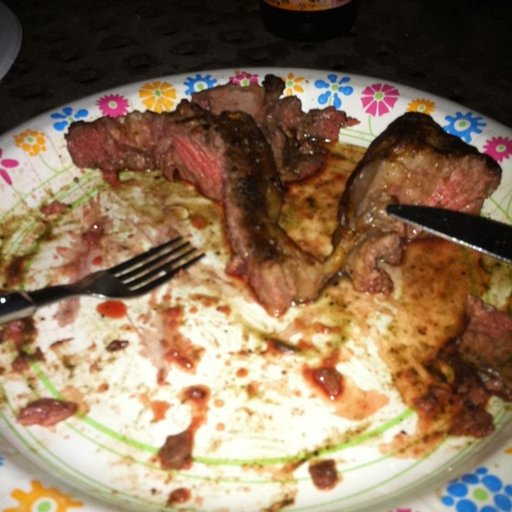

In [213]:
import random
from PIL import Image

#set seed
#random.seed(42) #Putting off the random seed will help in having different image for each run

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

#2. Pick a random image path
random_image_path = random.choice(image_path_list)

#3. Get the image from path name
image_class = random_image_path.parent.stem

#4. Open the image
img = Image.open(random_image_path)

#5. Print Metadata
print(f"Random image path: {random_image_path}")
print(f"Image size: {img.size}")
print(f"Image mode: {img.mode}")
print(f"Image class: {image_class}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

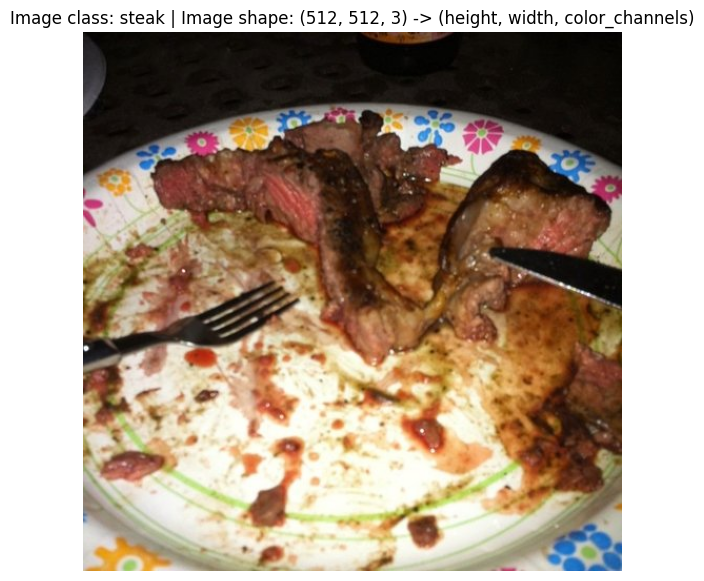

In [214]:
#Try to visualize images using Matplotlib

import numpy as np
import matplotlib.pyplot as plt

#Turn the image into an array
img_as_array = np.asarray(img)

#Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> (height, width, color_channels)")
plt.axis(False)

array([[[ 16,  15,  13],
        [ 11,  10,   8],
        [  5,   4,   2],
        ...,
        [  6,   4,   5],
        [  6,   4,   5],
        [  5,   3,   4]],

       [[ 22,  21,  19],
        [ 18,  17,  15],
        [ 13,  12,  10],
        ...,
        [  6,   4,   5],
        [  6,   4,   5],
        [  5,   3,   4]],

       [[ 26,  25,  23],
        [ 25,  24,  22],
        [ 20,  19,  17],
        ...,
        [  6,   4,   5],
        [  5,   3,   4],
        [  4,   2,   3]],

       ...,

       [[208, 196, 184],
        [209, 193, 177],
        [210, 188, 165],
        ...,
        [ 57, 104, 156],
        [ 75, 119, 168],
        [ 91, 135, 182]],

       [[210, 195, 166],
        [208, 189, 157],
        [205, 180, 139],
        ...,
        [ 71, 113, 163],
        [ 90, 128, 175],
        [106, 144, 189]],

       [[210, 194, 158],
        [206, 187, 145],
        [201, 173, 125],
        ...,
        [ 83, 121, 170],
        [101, 138, 183],
        [119, 153, 198]]], dtype=uint8)
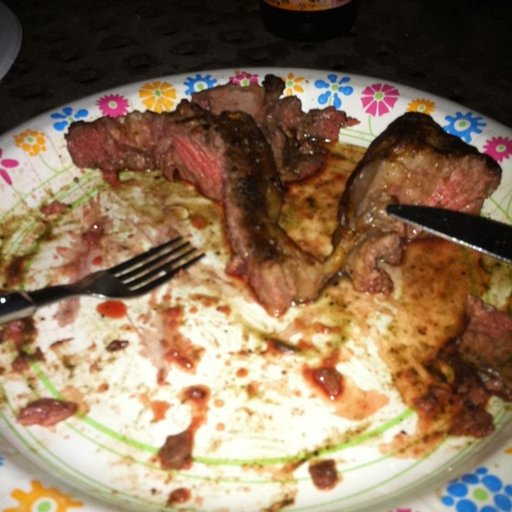

In [215]:
img_as_array

###Transforming data
Before we can use our image data with Pytorch:
1. Turn it into tensors (numerical representations of our images).
2. Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and DataLoader for short.

Since we're working with a vision problem, we'll be looking at

`torchvision.datasets` for our data loading functions as well as `torchvision.transforms` for preparing our data.

Let's import some base libraries.

In [216]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

##3.1. Transforming data with `torchvision.transforms`

In [217]:
#Write a transform for image
data_transform = transforms.Compose([
    #Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    #Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [218]:
data_transform(img).shape

torch.Size([3, 64, 64])

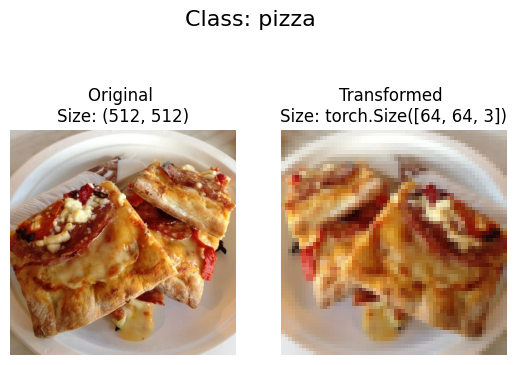

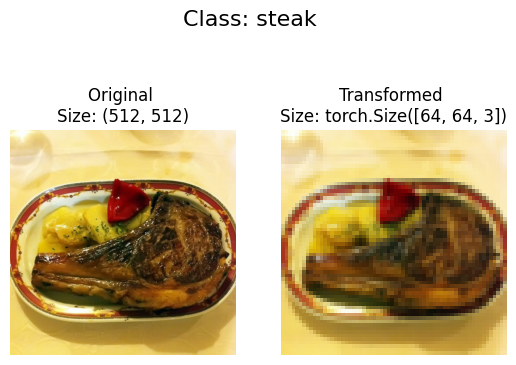

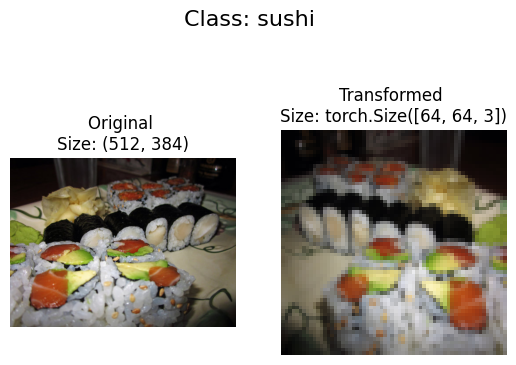

In [219]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=42):
  """Plots a series of random images from image_paths.

  Will open n image paths from image_paths, transform them
  with transform and plot them side by side. """

  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      #Transform and plot image
      transformed_image = transform(f).permute(1, 2, 0) # Note that we needed to change the order of the dimension for it to work. By removing the permute, there will be an error.
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

###4. Loading image data using **`ImageFolder `**

## We can load image classification data iusing `torchvision.datasets.ImageFolder`

In [220]:
#Use ImageFolder to create dataset(s)

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, #A transform for the data
                                  target_transform=None) #A transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [221]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [222]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [223]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [224]:
len(train_data), len(test_data)

(225, 75)

In [225]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [226]:
#Index on the train data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}\nImage datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'Image class: pizza')

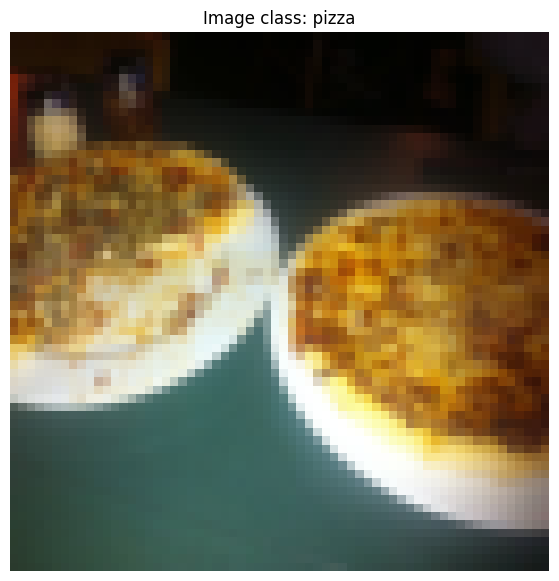

In [227]:
#Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

#print out different shapes
print(f"Image shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

#Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(f"Image class: {class_names[label]}")

### 4.1. Turn loaded images into **`DataLoader`**'s

A DataLoader is going to help us  turn our `Dataset`'s into iterable and we can customize the `batch_size` so our model can see `batch_size` images at a time.

In [228]:
#Turn train and test datasets into DataLoader's

from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                                batch_size=BATCH_SIZE,
                                num_workers=os.cpu_count(),
                                shuffle=True)

test_dataloader= DataLoader(dataset = test_data,
                            batch_size = 1,
                            num_workers = 1,
                            shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f1d5bef5a90>,
 <torch.utils.data.dataloader.DataLoader at 0x7f1d5c164e10>)

In [229]:
len(train_dataloader), len(test_dataloader)


(225, 75)

In [230]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


##5. Loading Image Data with a custom **`Dataset`**.

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset




In [231]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [232]:
#Instance of torchvision.datasets.ImageFolder
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want to:
1. Get the class names using os.scandir() to traverse a target directory
2. Raise an error if the class names are not found
3. Turn the class names into a dict and a list and return them

In [233]:
#Setup path for the target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

#Setup class names as a list
class_names_found = [entry.name for entry in os.scandir(target_directory) if entry.is_dir()]
print(f"Class names: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names: ['sushi', 'pizza', 'steak']


In [234]:
list(os.scandir(target_directory))

[<DirEntry 'sushi'>, <DirEntry 'pizza'>, <DirEntry 'steak'>]

In [235]:
from typing import Tuple, Dict, List

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """ Finds the class folder names in a target directory"""
  #1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if the class names could not be found
  if not classes:
    raise FileNotFoundError(f"I could not found any classes in {directory}... Please check file structure.")

  # 3. Create a dictionary of index labels
  class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
  return classes, class_to_idx

In [236]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

###5.2 Create a custom Dataset to replicate

To create our own dataset, we want to:

1. Subclass torch.utils.data.Dataset
2. Init our subclass with a target directory (the directory we would like to get data from) as well as transform if we would like to transform our data.

3. Create several attributes:
4. create a function to load_images(), this function will open an image
5. Overwrite the _len()_ method to return the length of our dataset
6. Overwrite the _getitem()_ method to return a given sample when passed an index

In [237]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [238]:
#Create a transform
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [239]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f1d5bf5c850>,
 <__main__.ImageFolderCustom at 0x7f1d5c1dbfd0>)

In [240]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f1d5bf5c850>,
 <__main__.ImageFolderCustom at 0x7f1d5c1dbfd0>)

In [241]:
len(train_data), len(train_data_custom)

(225, 225)

In [242]:
len(test_data), len(test_data_custom)

(75, 75)

In [243]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [244]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [245]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### 5.3. Create a function to display random images

Let's create a helper function called display_random_images() that helps us visualize images in our Dataset's.

Specifically, it'll:

1. Take in a Dataset and a number of other parameters such as classes (the names of our target classes), the number of images to display (n) and a random seed.

2. To prevent the display getting out of hand, we'll cap n at 10 images.
3. Set the random seed for reproducible plots (if seed is set).
4. Get a list of random sample indexes (we can use Python's random.sample() for this) to plot.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes found in step 4 and plot them with matplotlib.
7. Make sure the sample images are of shape HWC (height, width, color channels) so we can plot them.


In [246]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

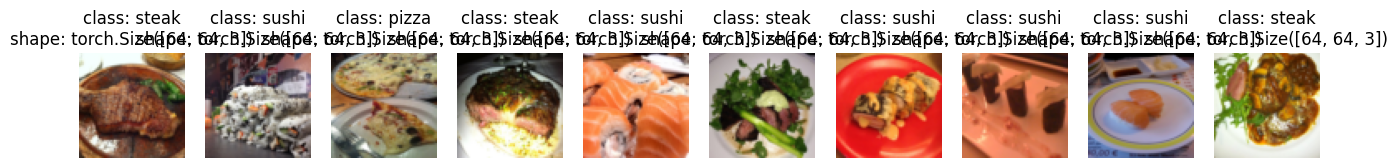

In [247]:
#Display random images from the imageFolder created Dataset
display_random_images(dataset=train_data_custom,
                      classes=train_data_custom.classes,
                      n=10,
                      seed=None)

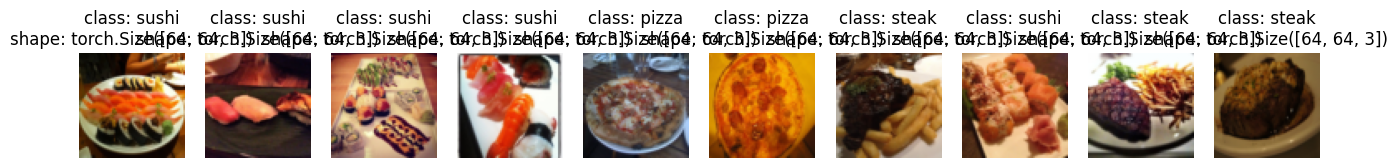

In [248]:
#Display random images from the ImageFolderCustom Dataset as well
display_random_images(dataset=train_data,
                      classes=train_data.classes,
                      n=10,
                      seed=None)

###5.4. Turn custom loaded images into **`DataLoader`**'s

In [249]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f1d5c6df650>,
 <torch.utils.data.dataloader.DataLoader at 0x7f1d5c45a510>)

In [250]:
#Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))
#Printing the shape
print(f"Image shape: {img_custom.shape}")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 64, 64])
Label shape: torch.Size([32])


## 6. Other forms of transforms (Data Augmentation)

**Data augmentation** is the process of altering your data in such a way that you artificially increase the diversity of your training set.

Training a model on this artificially altered dataset hopefully results in a model that is capable of better generalization (the patterns it learns are more robust to future unseen examples).


In [251]:
#Let us look at Trivialaugment

from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [252]:
image_path

PosixPath('data/pizza_steak_sushi')

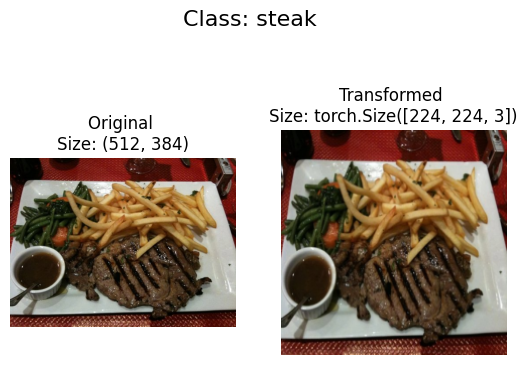

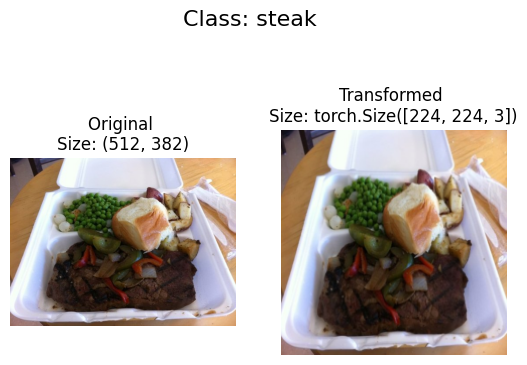

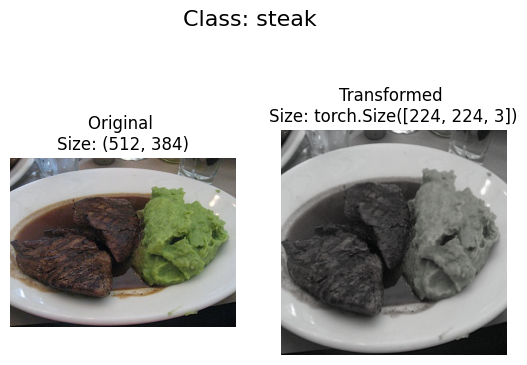

In [253]:
#Plot random transformed images

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

##7. TinyVGG without Data augmentation

###7.1. Creating transforms and loading data for Model 0

In [254]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [255]:
#1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform,
                                         target_transform=None)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# 3. Create DataLoaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=32,
                                     num_workers=os.cpu_count(),
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers= NUM_WORKERS)

### 7.2. Create TinyVGG model class

In [256]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion: Read more here: https://horace.io/brrr_intro.html

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

###7.3. Try a forward pass on a single image (To test the model)

In [257]:
#get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [258]:
#Try a forward pass
model_0(image_batch.to(device))

tensor([[0.0578, 0.0634, 0.0351],
        [0.0657, 0.0650, 0.0398],
        [0.0702, 0.0678, 0.0412],
        [0.0687, 0.0646, 0.0417],
        [0.0625, 0.0613, 0.0355],
        [0.0587, 0.0595, 0.0358],
        [0.0634, 0.0637, 0.0376],
        [0.0653, 0.0615, 0.0376],
        [0.0678, 0.0621, 0.0349],
        [0.0620, 0.0599, 0.0371],
        [0.0607, 0.0628, 0.0387],
        [0.0638, 0.0589, 0.0352],
        [0.0658, 0.0611, 0.0369],
        [0.0703, 0.0689, 0.0330],
        [0.0557, 0.0571, 0.0356],
        [0.0632, 0.0642, 0.0388],
        [0.0639, 0.0616, 0.0375],
        [0.0605, 0.0600, 0.0374],
        [0.0623, 0.0627, 0.0368],
        [0.0740, 0.0676, 0.0400],
        [0.0621, 0.0613, 0.0361],
        [0.0632, 0.0599, 0.0366],
        [0.0662, 0.0627, 0.0334],
        [0.0637, 0.0622, 0.0394],
        [0.0670, 0.0666, 0.0363],
        [0.0650, 0.0601, 0.0405],
        [0.0639, 0.0597, 0.0395],
        [0.0733, 0.0687, 0.0412],
        [0.0697, 0.0631, 0.0402],
        [0.062

###7.4. Use `torchinfo` to get an idea of the shapes going through our model


In [259]:
# Install torchinfo, import if it is available
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

###7.5. Create train and test loops functions


Specifically, we're going to make three functions:

1. `train_step()` - takes in a model, a DataLoader, a loss function and an optimizer and trains the model on the DataLoader.
2. `test_step()` - takes in a model, a DataLoader and a loss function and evaluates the model on the DataLoader.
3. `train()` - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

In [260]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [261]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

###7.6. Creating a `train()` function to combine to `train_step()` and `test_step()`

In [262]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

###7.7 Train and evaluate model 0

In [263]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1695 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.2891 | test_loss: 1.1342 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0989 | train_acc: 0.2930 | test_loss: 1.1434 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.0965 | train_acc: 0.3164 | test_loss: 1.1487 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.1190 | train_acc: 0.3164 | test_loss: 1.1427 | test_acc: 0.3021
Epoch: 8 | train_loss: 1.1016 | train_acc: 0.3555 | test_loss: 1.1053 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.0896 | train_acc: 0.4648 | test_loss: 1.0706 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.0685 | train_acc: 0.4023 | test_loss: 1.0205 | test_acc: 0.5417
Epoch: 11 | train_loss: 1.0431 | train_acc: 0.4180 | test_loss: 0.9819 | test_acc: 0.6042
Epoch: 12 | train_l

In [264]:
model_0_results

{'train_loss': [1.1078356355428696,
  1.084644928574562,
  1.1152610629796982,
  1.099034145474434,
  1.0989287495613098,
  1.0964747667312622,
  1.1190255880355835,
  1.1016480326652527,
  1.0895977467298508,
  1.0685038641095161,
  1.0430579110980034,
  1.1503405198454857,
  1.0440538376569748,
  0.9571545049548149,
  0.8947531878948212,
  0.791425546631217,
  0.8303239047527313,
  0.8415887206792831,
  0.8227127268910408,
  1.0298311933875084,
  0.8185457214713097,
  0.8443295210599899,
  0.8184354901313782,
  0.691279330290854,
  0.92511435598135,
  0.7862790934741497,
  0.8453308269381523,
  0.7354723680764437,
  0.6615754845552146,
  0.9447831362485886,
  0.7485459335148335,
  0.7095832973718643,
  0.6776270121335983,
  0.6270076483488083,
  0.6285710260272026,
  0.6474125608801842,
  0.630767185240984,
  0.5835866151610389,
  0.7428423278033733,
  0.8667158484458923,
  0.7186029925942421,
  0.5933136343955994,
  0.7116481363773346,
  0.709984801709652,
  0.5899312756955624,
  0.

###7.8. Plot the loss curves of Model 0

A loss curve is a way of tracking the model progress over time

In [265]:
#Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [266]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

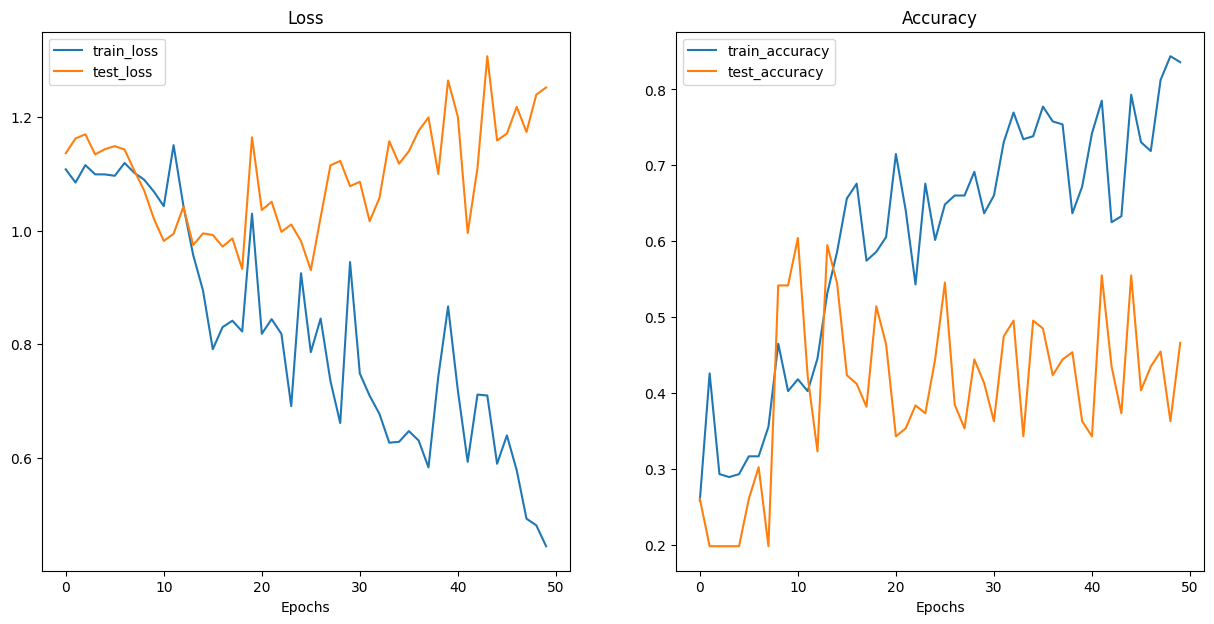

In [267]:
plot_loss_curves(model_0_results)

## 8. How should an ideal loss curve look like



###8.1. TinyVGG with Data augmentation

Now let us try another modelling experiment this time using the same model as before with some data augmentation

In [268]:
#Create Transform with data augmentation

#Create training transform with trivialAugment

from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

test_transform_simple = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])


###8.2. Create train and test dataset and dataloader with data augmentation

In [269]:
#Turn image folders into datasets
from torchvision import datasets

train_data_aug = datasets.ImageFolder(root=train_dir,
                                       transform=train_transform_trivial)
test_data_aug = datasets.ImageFolder(root=test_dir,
                                      transform=test_transform_simple)

In [270]:
#Turn our Datasets into Dataloader
import os
from torch.utils.data import dataloader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_aug = DataLoader(dataset=train_data_aug,
                                  batch_size=BATCH_SIZE,
                                  num_workers=NUM_WORKERS,
                                  shuffle=True)

torch.manual_seed(42)
test_dataloader_aug = DataLoader(dataset=test_data_aug,
                                 batch_size=BATCH_SIZE,
                                 num_workers=NUM_WORKERS,
                                 shuffle=False)

###9.3. Construct and train moddel1

This time we will be using the same model architecture excepts this time we have augmented the training data

In [271]:
#create model_1 and send the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_aug.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

Now we have gotten a model and dataloade, let create a loss function and an optimizer and call upon our `train_loss` to evaluate our model

In [272]:
#set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#set the number of epochs
NUM_EPOCHS = 50

#setup the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

#Start the timer
from timeit import default_timer as timer
start_time = timer()

#Train the model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_aug,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

#End the timer and print how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2500 | test_loss: 1.1062 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1387 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0811 | train_acc: 0.4258 | test_loss: 1.1696 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1291 | train_acc: 0.3047 | test_loss: 1.1624 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0901 | train_acc: 0.4258 | test_loss: 1.1477 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.0954 | train_acc: 0.3047 | test_loss: 1.1430 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.0877 | train_acc: 0.3984 | test_loss: 1.1383 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1061 | train_acc: 0.2930 | test_loss: 1.1485 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1206 | train_acc: 0.3281 | test_loss: 1.1543 | test_acc: 0.3125
Epoch: 10 | train_loss: 1.0765 | train_acc: 0.5117 | test_loss: 1.0940 | test_acc: 0.3220
Epoch: 11 | train_loss: 1.0598 | train_acc: 0.4453 | test_loss: 1.0601 | test_acc: 0.5152
Epoch: 12 | train_l

###8.4. Plot the loss curves of model 1

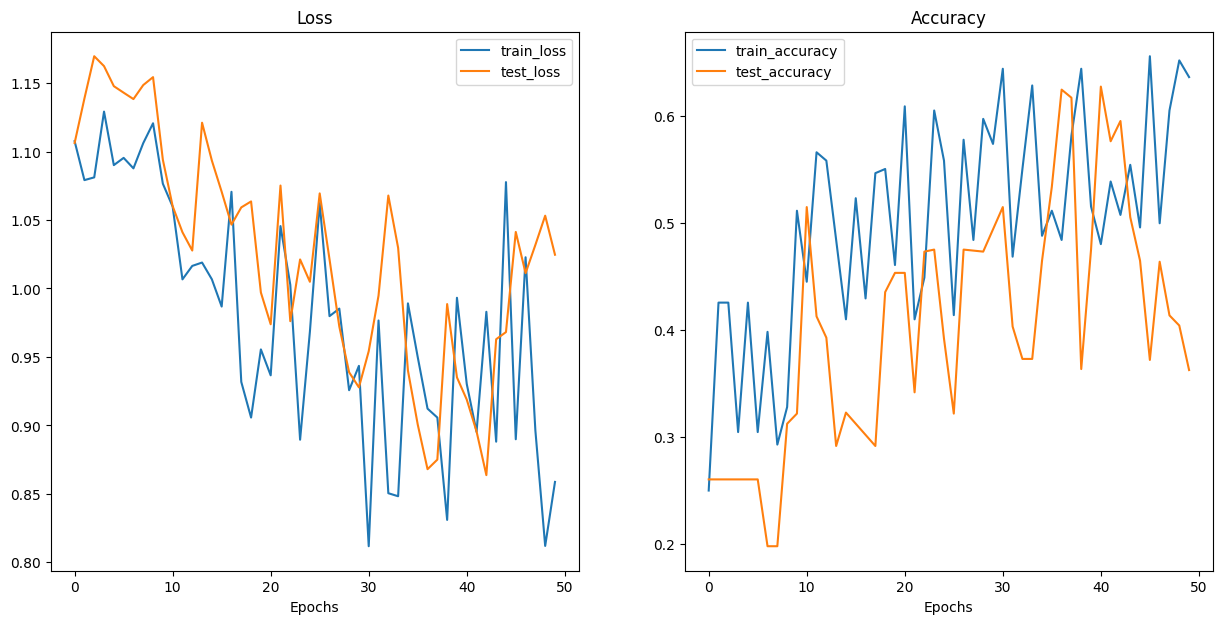

In [273]:
plot_loss_curves(model_1_results)

##9. Compare the model results side by side.

In [274]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0     1.107836   0.257812   1.136208  0.260417
1     1.084645   0.425781   1.162168  0.197917
2     1.115261   0.292969   1.169467  0.197917
3     1.099034   0.289062   1.134167  0.197917
4     1.098929   0.292969   1.143351  0.197917
5     1.096475   0.316406   1.148693  0.260417
6     1.119026   0.316406   1.142659  0.302083
7     1.101648   0.355469   1.105323  0.197917
8     1.089598   0.464844   1.070603  0.541667
9     1.068504   0.402344   1.020545  0.541667
10    1.043058   0.417969   0.981881  0.604167
11    1.150341   0.402344   0.994488  0.422348
12    1.044054   0.445312   1.041991  0.322917
13    0.957155   0.531250   0.974726  0.594697
14    0.894753   0.585938   0.995122  0.544508
15    0.791426   0.656250   0.992439  0.423295
16    0.830324   0.675781   0.971939  0.411932
17    0.841589   0.574219   0.986279  0.381629
18    0.822713   0.585938   0.932567  0.514205
19    1.029831   0.605469   1.164221  0.464015
20    0.818546   0.714844   1.036399  0.342803
21    0.844330   0.640625   1.050826  0.353220
22    0.818435   0.542969   0.997908  0.383523
23    0.691279   0.675781   1.010755  0.373106
24    0.925114   0.601562   0.981499  0.444129
25    0.786279   0.648438   0.930567  0.545455
26    0.845331   0.660156   1.023450  0.384470
27    0.735472   0.660156   1.114861  0.353220
28    0.661575   0.691406   1.122685  0.444129
29    0.944783   0.636719   1.078213  0.412879
30    0.748546   0.660156   1.085937  0.362689
31    0.709583   0.730469   1.016590  0.474432
32    0.677627   0.769531   1.057565  0.495265
33    0.627008   0.734375   1.157277  0.342803
34    0.628571   0.738281   1.117750  0.495265
35    0.647413   0.777344   1.139661  0.484848
36    0.630767   0.757812   1.175617  0.423295
37    0.583587   0.753906   1.199144  0.444129
38    0.742842   0.636719   1.099803  0.453598
39    0.866716   0.671875   1.264165  0.362689
40    0.718603   0.742188   1.200090  0.342803
41    0.593314   0.785156   0.995888  0.554924
42    0.711648   0.625000   1.110265  0.434659
43    0.709985   0.632812   1.306826  0.373106
44    0.589931   0.792969   1.158662  0.554924
45    0.639797   0.730469   1.170756  0.403409
46    0.578624   0.718750   1.217694  0.434659
47    0.493341   0.812500   1.173562  0.454545
48    0.481614   0.843750   1.239384  0.362689
49    0.444898   0.835938   1.251850  0.465909

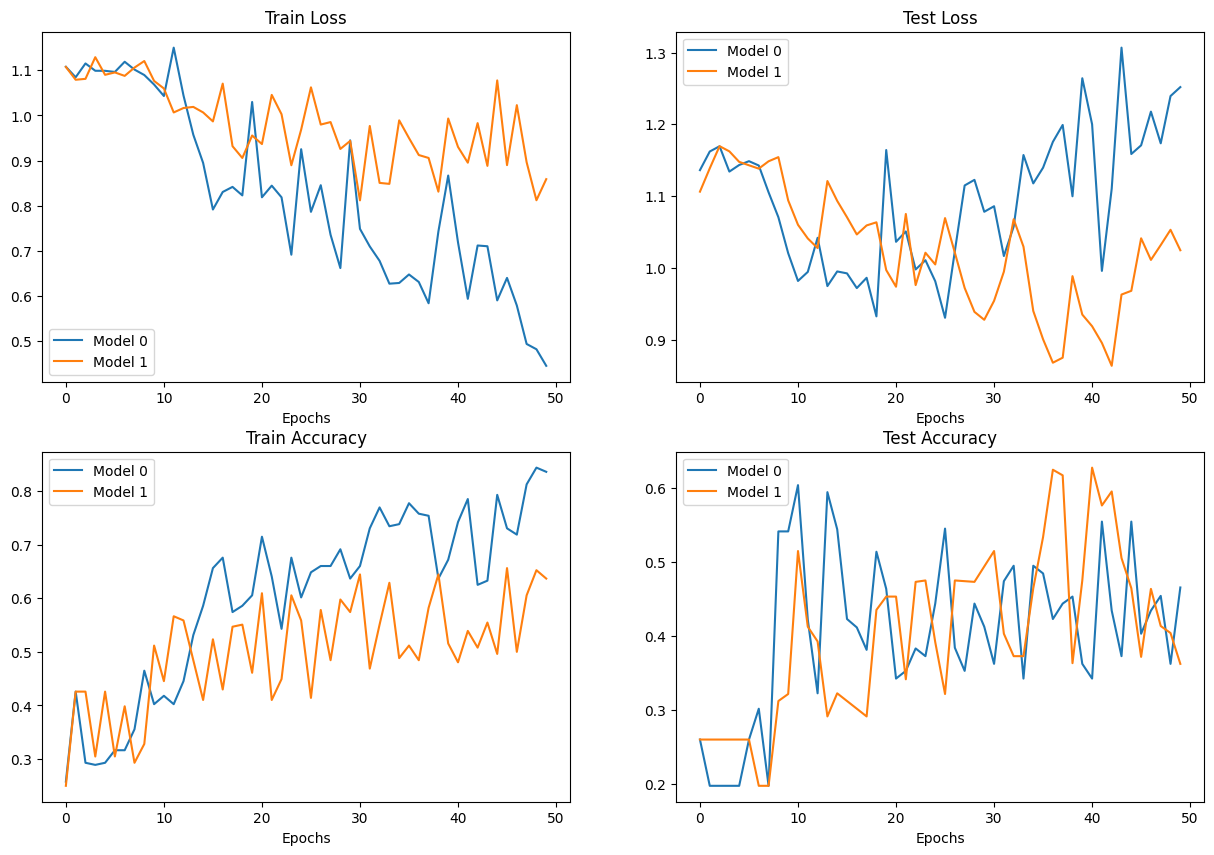

In [275]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

##10. Make a prediction on a custom image

In our case, since we've trained a model on pizza, steak and sushi images, how could we use our model to make a prediction on one of our own images?

To do so, we can load an image and then preprocess it in a way that matches the type of data our model was trained on.

In other words, we'll have to convert our own custom image to a tensor and make sure it's in the right datatype before passing it to our model.

Let's start by downloading a custom image.

In [279]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data/04-pizza-dad.jpeg already exists, skipping download.


###11.1. Loading in a custom image with Pytorch

PyTorch's torchvision has several input and output ("IO" or "io" for short) methods for reading and writing images and video in torchvision.io.

Since we want to load in an image, we'll use torchvision.io.read_image().

This method will read a JPEG or PNG image and turn it into a 3 dimensional RGB or grayscale torch.Tensor with values of datatype uint8 in range [0, 255].

In [277]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

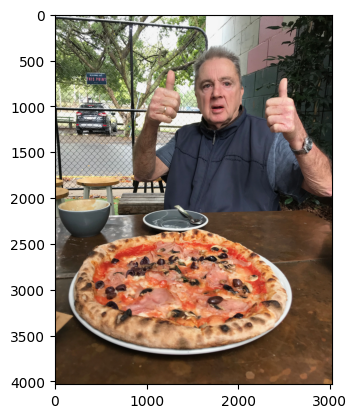

In [278]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

###11.2. Making a prediction on a custom image with a trained Pytorch model

In [283]:
#Try to make prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

Let's fix this by converting our custom image to the same datatype as what our model was trained on (`torch.float32`).

In [284]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

###11.3 Predicting on custom images with a trained PyTorch model

The steps to make a prediction on a custom image are:
1. Load the image.
2. Prepare the image (resize, convert to tensor, normalize, add batch dimension, move to device).
3. Make a prediction with the trained model (forward pass).
4. Convert the model output logits to a predicted label.

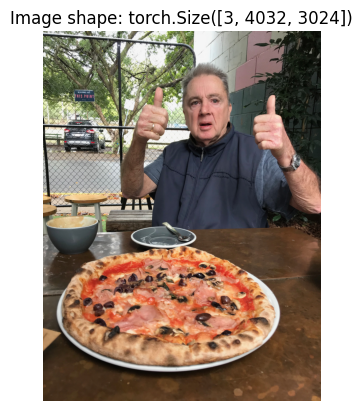

In [285]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

Now how could we get our image to be the same size as the images our model was trained on?

One way to do so is with torchvision.transforms.Resize().

Let's compose a transform pipeline to do so.

In [286]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


Let us try again to do the prediction on our image:


In [287]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

Let's fix that by putting our custom_image_transformed on the target device.

In [288]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

There's one dimension we forgot about.

The batch size.

Our model expects image tensors with a batch size dimension at the start (**NCHW** where N is the batch size).

Except our custom image is currently only CHW.

We can add a batch size dimension using torch.unsqueeze(`dim=0`) to add an extra dimension our image and finally make a prediction.

Essentially we'll be telling our model to predict on a single image (an image with a `batch_size of 1`).

In [289]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


How to go through this fix anytime we will be finding these kinds of errors:

What we've just gone through are three of the classical and most common deep learning and PyTorch issues:

1. **Wrong datatypes** - our model expects torch.float32 where our original custom image was uint8.
2. **Wrong device** - our model was on the target device (in our case, the GPU) whereas our target data hadn't been moved to the target device yet.
3. **Wrong shapes** - our model expected an input image of shape `[N, C, H, W]` or `[batch_size, color_channels, height, width]` whereas our custom image tensor was of shape `[color_channels, height, width]`.

In [290]:
#Convert logits -> prediction probabilities
custom_image_pred_labels = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_labels

tensor([[0.6335, 0.1661, 0.2004]], device='cuda:0')

In [291]:
#Convert prediction probabilities -> prediction labels
custom_image_pred_labels = torch.argmax(custom_image_pred_labels, dim=1).cpu()
custom_image_pred_labels

tensor([0], device='cuda:0')

In [292]:
class_names[custom_image_pred_labels]

'pizza'

###11.4. Putting custom image prediction together: Building a function


Specifically, let's make a function that:

1. Takes in a target image path and converts to the right datatype for our model (torch.float32).
2. Makes sure the target image pixel values are in the range [0, 1].
3. Transforms the target image if necessary.
4. Makes sure the model is on the target device.
5. Makes a prediction on the target image with a trained model (ensuring the image is the right size and on the same device as the model).
6. Converts the model's output logits to prediction probabilities.
7. Converts the prediction probabilities to prediction labels.
8. Plots the target image alongside the model prediction and prediction probability.

In [293]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

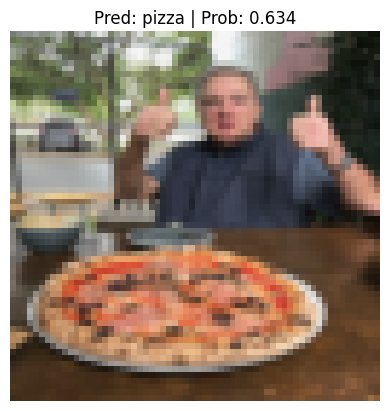

In [296]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

# **FINAL: NOW YOU ARE GOOD TO GO...**